In [ ]:

!mkdir -p ~/.kaggle
!cp kaggle-2.json ~/.kaggle/

cp: cannot stat 'kaggle-2.json': No such file or directory


In [ ]:
! kaggle datasets download -d "ashfakyeafi/cat-dog-images-for-classification"

Dataset URL: https://www.kaggle.com/datasets/ashfakyeafi/cat-dog-images-for-classification
License(s): CC0-1.0
 99% 537M/545M [00:14<00:00, 87.9MB/s]
100% 545M/545M [00:14<00:00, 39.4MB/s]


In [ ]:

import zipfile
zip_ref = zipfile.ZipFile('/content/cat-dog-images-for-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import pandas as pd
import numpy as np

In [ ]:

data=pd.read_csv('/content/cat_dog.csv')
data.head()

,image,labels
0,dog.11289.jpg,1
1,cat.10836.jpg,0
2,cat.7970.jpg,0
3,cat.2212.jpg,0
4,dog.2653.jpg,1


In [ ]:
# Add the full image path to the DataFrame
import os
from sklearn.model_selection import train_test_split

data["image_path"] = data["image"].apply(lambda x: os.path.join("/content/cat_dog", x))

# Filter out files that are not present in the directory
data = data[data["image_path"].apply(os.path.exists)]

# Split the data into training, validation, and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data["labels"], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data["labels"], random_state=42)


In [ ]:
# Data generators for memory efficiency
import tensorflow as tf

image_size = (128, 128)
batch_size = 32

# Data Augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:

def preprocess_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = img / 255.0
    return img, label

In [ ]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data["image_path"].values, train_data["labels"].values))
train_dataset = train_dataset.map(preprocess_image).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_data["image_path"].values, val_data["labels"].values))
val_dataset = val_dataset.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data["image_path"].values, test_data["labels"].values))
test_dataset = test_dataset.map(preprocess_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:


# Build a CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import warnings
warnings.filterwarnings('ignore')

model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [ ]:
# Compile the model with a reduced learning rate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

optimizer = Adam(learning_rate=0.0001)
model1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for Early Stopping and Learning Rate Reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train the model
history = model1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.6488 - loss: 4.2223 - val_accuracy: 0.7048 - val_loss: 3.1577 - learning_rate: 1.0000e-04
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 35s 47ms/step - accuracy: 0.7670 - loss: 2.8362 - val_accuracy: 0.7795 - val_loss: 2.2023 - learning_rate: 1.0000e-04
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.8029 - loss: 2.0256 - val_accuracy: 0.7657 - val_loss: 1.7160 - learning_rate: 1.0000e-04
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.8284 - loss: 1.5363 - val_accuracy: 0.7722 - val_loss: 1.4489 - learning_rate: 1.0000e-04
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.8503 - loss: 1.2418 - val_accuracy: 0.8158 - val_loss: 1.1933 - learning_rate: 1.0000e-04
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.8738 - loss: 1.0510 - val_accuracy: 0.8087 - val_loss: 1.1152 - learning_rate: 1.0000e-04
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/ste

In [ ]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,916,101 (37.83 MB)

 Trainable params: 3,305,217 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 6,610,436 (25.22 MB)

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model1.evaluate(test_dataset, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}, Test Loss: {test_loss:.2f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8849 - loss: 0.5262
Test Accuracy: 0.88, Test Loss: 0.53


In [ ]:
# Sample 50 images from the test dataset
sample_dataset = test_dataset.unbatch().take(100)

# Prepare lists to store images, true labels, and predictions
images, true_labels, predictions = [], [], []

# Collect the images, true labels, and predictions
for img, label in sample_dataset:
    images.append(img.numpy())
    true_labels.append(label.numpy())
    prediction = model1.predict(tf.expand_dims(img, axis=0))[0][0]
    predictions.append(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━

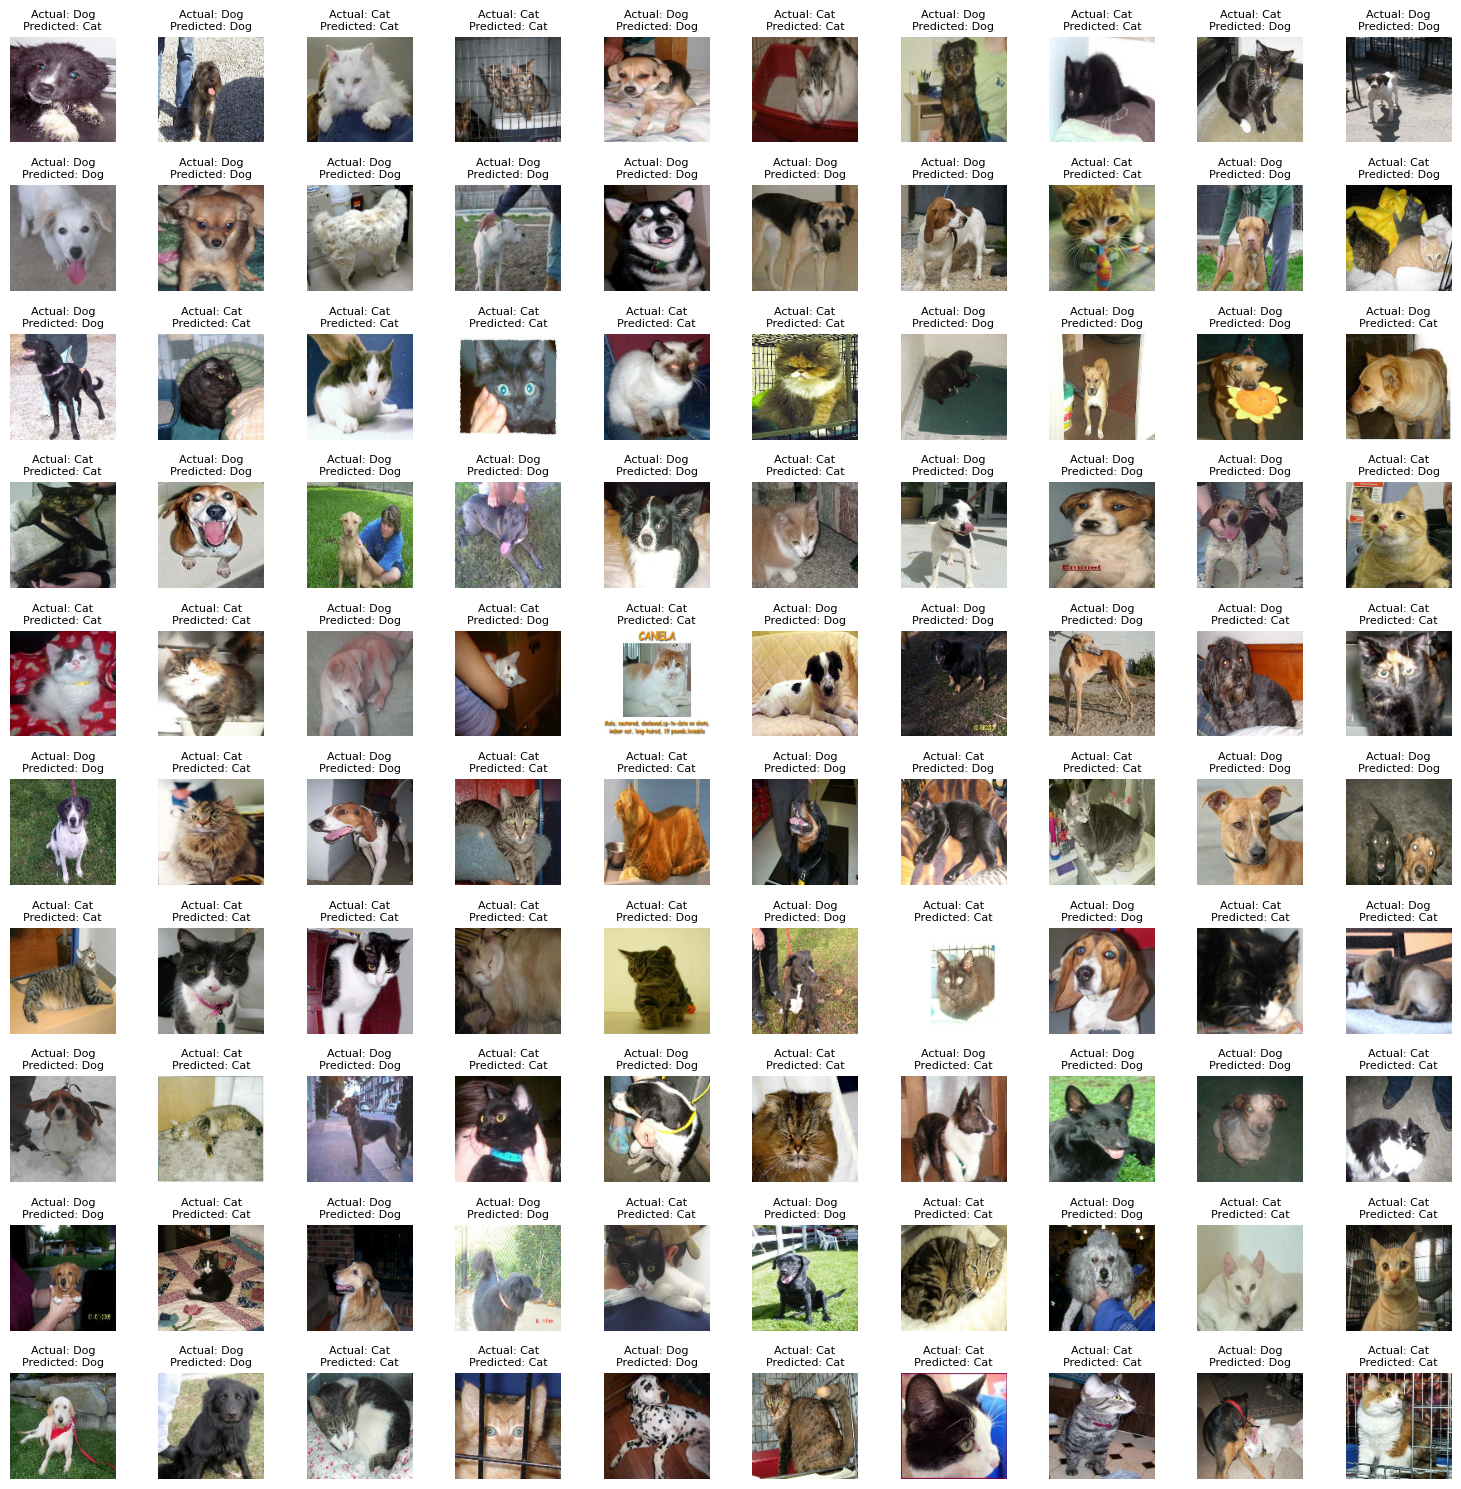

In [ ]:

# Plot the 10x10 grid
import matplotlib.pyplot as plt

fig, axes = plt.subplots(10, 10, figsize=(15, 15))
axes = axes.flatten()

for i in range(100):
    ax = axes[i]
    ax.imshow(images[i])
    ax.axis('off')

    true_label = "Dog" if true_labels[i] == 1 else "Cat"
    predicted_label = "Dog" if predictions[i] > 0.5 else "Cat"
    ax.set_title(f"Actual: {true_label}\nPredicted: {predicted_label}", fontsize=8)

plt.tight_layout()
plt.show()

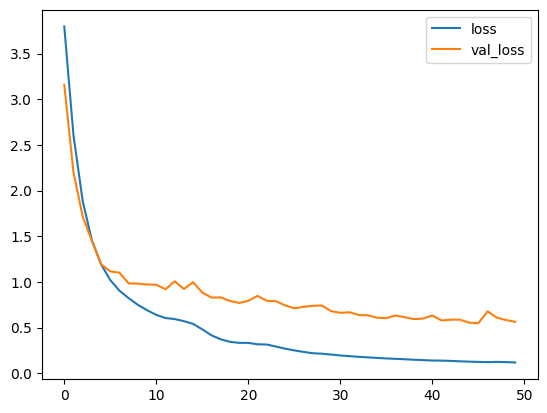

In [ ]:

# loss vs val_loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])

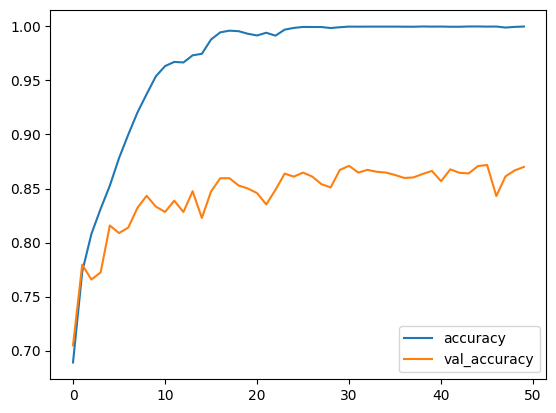

In [ ]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])

# VGG16 Model

In [ ]:
train_data['labels'] = train_data['labels'].astype(str)
val_data['labels'] = val_data['labels'].astype(str)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# Data preprocessing
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='image_path',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')
validation_generator = validation_datagen.flow_from_dataframe(
    val_data,
    x_col='image_path',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

Found 16000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.


In [ ]:

from tensorflow.keras.applications import VGG16

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Freeze base model
base_model.trainable = False

# Add custom layers
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('vgg16_cat_dog.keras', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    batch_size=64,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 259s 473ms/step - accuracy: 0.8050 - loss: 0.5042 - val_accuracy: 0.9185 - val_loss: 0.1906
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 244s 472ms/step - accuracy: 0.8955 - loss: 0.2503 - val_accuracy: 0.9305 - val_loss: 0.1693
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 260s 466ms/step - accuracy: 0.9038 - loss: 0.2291 - val_accuracy: 0.9377 - val_loss: 0.1516
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 234s 463ms/step - accuracy: 0.9042 - loss: 0.2207 - val_accuracy: 0.9373 - val_loss: 0.1523
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 272s 479ms/step - accuracy: 0.9138 - loss: 0.2044 - val_accuracy: 0.9193 - val_loss: 0.1880
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 238s 472ms/step - accuracy: 0.9177 - loss: 0.1995 - val_accuracy: 0.9358 - val_loss: 0.1502
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 258s 464ms/step - accuracy: 0.9205 - loss: 0.1898 - val_accuracy: 0.9342 - val_loss: 0.1559
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 264s 469ms/step - accuracy: 0.9200 -

In [ ]:

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,983,813 (129.64 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 12,846,084 (49.00 MB)

In [ ]:

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Test Accuracy: {test_accuracy:.2f}, Test Loss: {test_loss:.2f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.9386 - loss: 0.1467
Test Accuracy: 0.94, Test Loss: 0.14


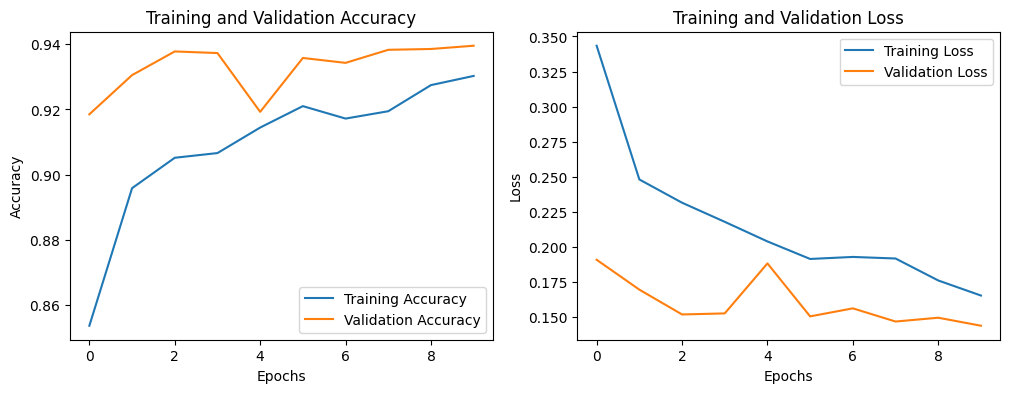

In [ ]:


# plot training and validation curves
def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

plot_learning_curves(history)

